В данном ноутбуке мы решим задачу оценки зарплаты пользователя по указанным данным.

**Импортируемые модули**

In [ ]:
# @title Libraries

# Работа с массивами данных
import numpy as np

# Работа с табличными данными
import pandas as pd

# Функции-утилиты для работы с категориальными данными
from tensorflow.keras import utils

# Класс для конструирования последовательной модели нейронной сети
from tensorflow.keras.models import Sequential, Model

# Основные слои
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation, Input, concatenate
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D

# Оптимизаторы
from tensorflow.keras.optimizers import Adam, Adadelta, SGD, Adagrad, RMSprop

# Токенизатор для преобразования текстов в последовательности
from tensorflow.keras.preprocessing.text import Tokenizer

# Масштабирование данных
from sklearn.preprocessing import StandardScaler

# Загрузка датасетов из облака google
import gdown

# Регулярные выражения
import re

# Отрисовка графиков
import matplotlib.pyplot as plt

# Метрики для расчета ошибок
from sklearn.metrics import mean_squared_error, mean_absolute_error

%matplotlib inline

## Парсинг (обработка) базы

Скачаем базу для работы:

In [ ]:
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l10/hh_fixed.csv', None, quiet=True)
!rm -r sample_data

Давайте посмотрим на данные, с которыми нам предстоит работать:

In [ ]:
# Чтение файла базы данных
df = pd.read_csv('hh_fixed.csv', index_col=0)
display(df.head(3))
print(df.shape)

,"Пол, возраст",ЗП,Ищет работу на должность:,Город,Занятость,График,Опыт (двойное нажатие для полной версии),Последенее/нынешнее место работы,Последеняя/нынешняя должность,Образование и ВУЗ,Обновление резюме,Авто
0,"Мужчина , 29 лет , родился 16 мая 1989",40000 руб.,Специалист по поддержке чата(support team) дом...,"Новороссийск , готов к переезду (Анапа, Геленд...",полная занятость,полный день,Опыт работы 3 года 9 месяцев Специалист по по...,"ООО ""Гольфстрим""",Генеральный директор,Высшее образование 2011 Международный юридиче...,26.04.2019 08:04,Не указано
1,"Мужчина , 38 лет , родился 25 мая 1980",40000 руб.,Системный администратор,"Новосибирск , м. Березовая роща , не готов к ...",полная занятость,полный день,Опыт работы 11 лет 11 месяцев Системный админ...,ООО «Завод модульных технологий»,Системный администратор,Высшее образование 2002 Новосибирский государс...,26.04.2019 04:30,Не указано
2,"Мужчина , 35 лет , родился 14 июня 1983",300000 руб.,DevOps TeamLead / DevOps архитектор,"Москва , готов к переезду , готов к редким ком...",полная занятость,полный день,Опыт работы 12 лет 11 месяцев DevOps TeamLead...,Банк ВТБ (ПАО),Начальник отдела методологии разработки (DevOp...,DevOps TeamLead / DevOps архитектор 300 000 ру...,09.04.2019 14:40,Не указано


(62967, 12)


In [ ]:
from tabulate import tabulate

n = 2  # Индекс в таблице резюме
data = []
for i in range(df.columns.shape[0]):  # Вывод значения каждого столбца
    data.append([f'\033[91m{df.columns[i]}:\033[0m', df.values[n][i]])

print(tabulate(data, tablefmt="grid"))


+-------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

В представленной таблице собраны примеры резюме пользователей. Нашим целевым параметром (значением, которое должна будет предсказать нейронная сеть), будет колонка ЗП.

Остальные столбцы (за исключением двух последних) мы будем использовать как x_train, в качестве оцениваемых параметров.

Наша главная задача: **подготовить данные для подачи в сеть**. В таблице собраны данные различных типов: текстовые, числовые, категориальные. Все это нужно правильно обработать перед подачей в сеть. Для каждого столбца мы подготовим специальную функцию, которая будет парсить (обрабатывать) данные из этого столбца. В итоге мы подготовим обучающую выборку, содержащую все данные из представленной таблицы.

Прежде чем вы приступите к парсингу таблицы, рекомендуем вам ознакомится с дополнительными материалами на тему "Функциональное программирование в Keras" (ссылка ниже). Керас является гибким и мощным инструментом проектирования нейронных сетей, позволяющим создавать как линейные, так и нелинейные архитектуры:

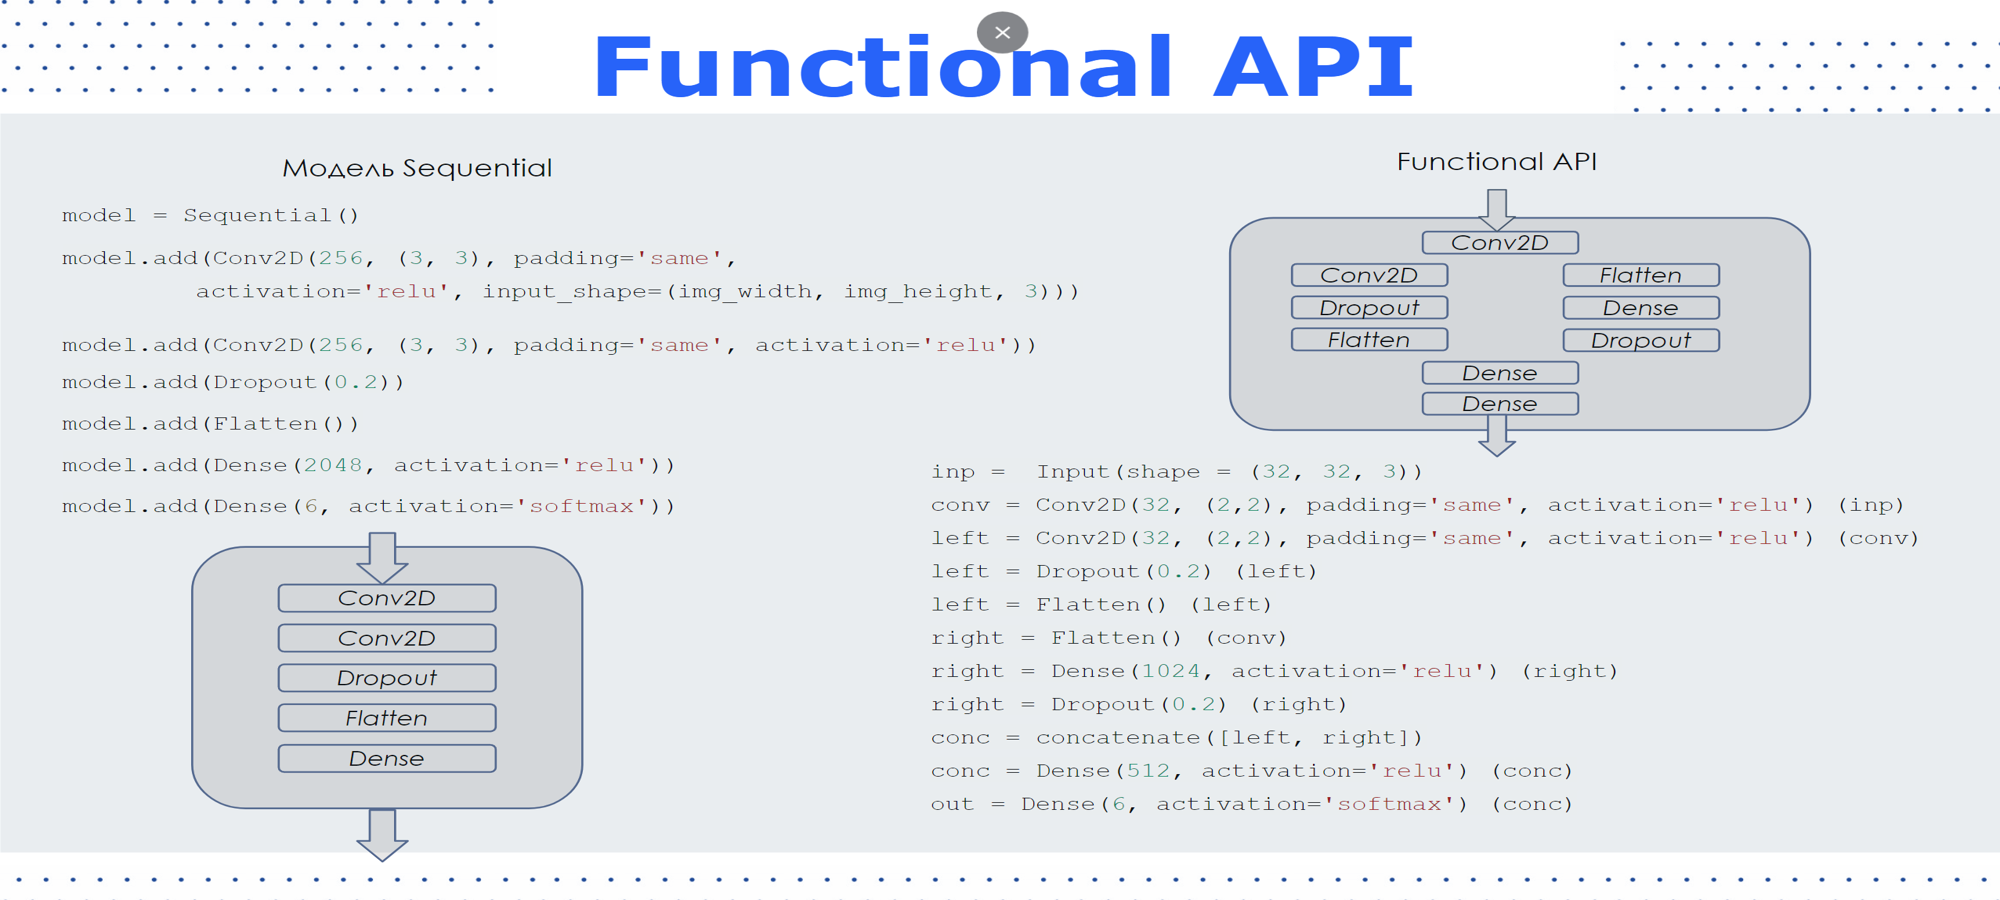

При помощи .get_loc() зафиксируйте номер столбца в определенной переменной. Это упростит обращение к столбцу и сделает код меньше и понятней:

In [ ]:
df.head(0)

,"Пол, возраст",ЗП,Ищет работу на должность:,Город,Занятость,График,Опыт (двойное нажатие для полной версии),Последенее/нынешнее место работы,Последеняя/нынешняя должность,Образование и ВУЗ,Обновление резюме,Авто


In [ ]:
# Настройка номеров столбцов
# Дальнейшие вычисления не будут зависеть от порядка столбцов в таблице

COL_SEX_AGE     = df.columns.get_loc('Пол, возраст')
COL_SALARY      = df.columns.get_loc('ЗП')
COL_POS_SEEK    = df.columns.get_loc('Ищет работу на должность:')
COL_POS_PREV    = df.columns.get_loc('Последеняя/нынешняя должность')
COL_CITY        = df.columns.get_loc('Город')
COL_EMPL        = df.columns.get_loc('Занятость')
COL_SCHED       = df.columns.get_loc('График')
COL_EXP         = df.columns.get_loc('Опыт (двойное нажатие для полной версии)')
COL_EDU         = df.columns.get_loc('Образование и ВУЗ')
COL_UPDATED     = df.columns.get_loc('Обновление резюме')

Теперь можем написать ряд функций для парсинга (обработки) нашей таблицы.

In [ ]:
def purify(x):
    if isinstance(x, str):                # Если значение - строка:
        # Замена концов строк на пробелы, удаление символа с кодом 0xA0,
        # обрезка краевых пробелов и приведение к нижнему регистру
        x = x.replace('\n', ' ').replace('\xa0', '').strip().lower()
    return x

Функция `purify()` написана для очистки текста в таблице с данными. Она убирает из строки следующие символы:
- `\n`;
- `\xa0`;
- пробелы по краям.

А также приводит все символы к нижнему регистру.


Например:

In [ ]:
text = '    Мама\xa0 мыла\nРАМУ       \xa0 '


print('\033[92m=\033[0m' * 35)
print(f'\033[91mНеочищенная строка:\033[0m {text}')
print('\033[92m=\033[0m' * 35)
print(f'\033[94mОбработанная строка:\033[0m {purify(text)}')
print('\033[92m=\033[0m' * 35)

Неочищенная строка:     Мама  мыла
РАМУ         
Обработанная строка: мама мыла раму


Функция `extract_year()` выделяет из строки подстроку вида ДД.ММ.ГГГГ и возвращает значение года:

In [ ]:
def extract_year(x):
    try:
        return int(re.search(r'\d\d.\d\d.(\d{4})', x)[1])   # Ожидается строка вида 'dd.mm.yyyy ...'

    except (IndexError, TypeError, ValueError):
        return 0

Здесь мы воспользовались конструкцией `try except` для обработки исключений. Буквально запись выше означает:
1. пробуем выполнить код:

        int(re.search(r'\d\d.\d\d.(\d{4})', x)[1])
    
2. Если код выполняется без ошибок, то функция `extract_year()` возвращает полученное значение

3. Если код выполняется с ошибкой, то программа не вылетает и функция попадает в блок `except` и возвращает 0
  

Здесь же мы воспользовались библиотекой `re` - библиотекой регулярных выражений. Более подробно об этой библиотеке можете узнать по ссылке ниже:

In [ ]:
text = 'Пётр первый родился в ночь на 30.05.1672'

print(f'\033[94mИсходный текст:\033[0m {text}')
print(f'\033[91mПосле extract_year:\033[0m {extract_year(text)}')

Исходный текст: Пётр первый родился в ночь на 30.05.1672
После extract_year: 1672


Следующим блоком кода вы создадите словари и списки значений для разбиения на классы

Например, список `city_class` содержит в себе словарь вида `{город: класс города}`

Списки `age_class` и `experience_class` содержат в себе пороговые значения, которые будут определять, к какому классу относить возраст или опыт человека:


In [ ]:
### Параметрические данные для функций разбора ###

# Курсы валют для зарплат
currency_rate = {
    'usd'    : 90.3532,     # 1 USD = 90.3532 RUB[^1^][1]
    'kzt'    : 0.200,       # 1 KZT = 0.200 RUB
    'грн'    : 2.42,        # 1 UAH = 2.42 RUB
    'белруб' : 27.5,        # 1 BYN = 27.5 RUB[^1^][1]
    'eur'    : 98.0,        # 1 EUR = 98.0 RUB
    'kgs'    : 0.96,        # 1 KGS = 0.96 RUB
    'сум'    : 0.0076,      # 1 UZS = 0.0076 RUB
    'azn'    : 53.0         # 1 AZN = 53.0 RUB
}


# Списки и словари для разбиения на классы
# Для ускорения работы добавлен счетчик классов, который будет вычислен ниже

# Список порогов возраста
age_class = [0, [18, 23, 28, 33, 38, 43, 48, 53, 58, 63]]

# Список порогов опыта работы в месяцах
experience_class = [0, [7, 13, 25, 37, 61, 97, 121, 157, 193, 241]]

# Классы городов
city_class = [0,
              {'москва'          : 0,
               'санкт-петербург' : 1,
               'новосибирск'     : 2,
               'екатеринбург'    : 2,
               'нижний новгород' : 2,
               'казань'          : 2,
               'челябинск'       : 2,
               'омск'            : 2,
               'самара'          : 2,
               'ростов-на-дону'  : 2,
               'уфа'             : 2,
               'красноярск'      : 2,
               'пермь'           : 2,
               'воронеж'         : 2,
               'волгоград'       : 2,
               'прочие города'   : 3
              }]

# Классы занятости
employment_class = [0,
                    {'стажировка'          : 0,
                     'частичная занятость' : 1,
                     'проектная работа'    : 2,
                     'полная занятость'    : 3
                    }]

# Классы графика работы
schedule_class = [0,
                  {'гибкий график'         : 0,
                   'полный день'           : 1,
                   'сменный график'        : 2,
                   'удаленная работа'      : 3
                  }]

# Классы образования
education_class = [0,
                   {'высшее образование'   : 0,
                    'higher education'     : 0,
                    'среднее специальное'  : 1,
                    'неоконченное высшее'  : 2,
                    'среднее образование'  : 3
                   }]


Как вы заметили, помимо меток классов и пороговых значений есть одно число, которое стоит на первом месте. Пока это просто нули, но следующим блоком кода вы измените их на количество различных классов

Например, для `age_class` это значение будет равно `11`, а для `city_class` – `4`.


In [ ]:
'''Проверяем, принадлежит ли объект к определенному типу данных. '''

x = 5
print(isinstance(x, int))  # Выведет True, потому что x является целым числом (int)

y = "hello"
print(isinstance(y, int))  # Выведет False, потому что y не является целым числом (int)


True
False


In [ ]:
our_classes = [
    age_class,            # Класс, содержащий данные о возрасте
    experience_class,     # Класс, содержащий данные об опыте работы
    city_class,           # Класс, содержащий данные о городе проживания
    employment_class,     # Класс, содержащий данные о типе занятости
    schedule_class,       # Класс, содержащий данные о графике работы
    education_class       # Класс, содержащий данные об уровне образования
]


# Вычисление счетчиков для данных разбиения
for class_desc in our_classes:

    if isinstance(class_desc[1], list):
        class_desc[0] = len(class_desc[1]) + 1

    else:
        class_desc[0] = max(class_desc[1].values()) + 1

Проверим список `age_class`:

In [ ]:
age_class

[11, [18, 23, 28, 33, 38, 43, 48, 53, 58, 63]]

Как видите, теперь первым элементов стоит число `11` - количество категорий

Функция `int_to_ohe()` возвращает one hot encoding представление значения класса.

Что это значит?

Если количество классов равно 5, то one hot представление для класса `0` будет: `[1, 0, 0, 0, 0]`.

А, например, для класса 3 - `[0, 0, 0, 1, 0]`

In [ ]:
def int_to_ohe(arg, class_list):

    # Определение размерности выходного вектора
    num_classes = class_list[0]

    # Поиск верного интервала для входного значения
    for i in range(num_classes - 1):
        if arg < class_list[1][i]:
            cls = i                       # Интервал найден - назначение класса
            break
    else:                                 # Внимание: for/else
        cls = num_classes - 1            # Интервал не найден - последний класс

    # Возврат в виде one hot encoding-вектора
    return utils.to_categorical(cls, num_classes)

age = 63
int_to_ohe(age, age_class)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)

Функция `str_to_multi()` сопоставляет строковому значению метку класса.

Функционально это то же самое, что и предыдущий случай, но для `age_class`, `experience_class` и т. д.


In [ ]:
# Общая функция преобразования строки к multi-вектору
# На входе данные и словарь сопоставления подстрок классам

def str_to_multi(arg, class_dict):
    # Определение размерности выходного вектора
    num_classes = class_dict[0]

    # Создание нулевого вектора
    result = np.zeros(num_classes)

    # Поиск значения в словаре и, если найдено,
    # выставление 1. на нужной позиции
    for value, cls in class_dict[1].items():
        if value in arg:
            result[cls] = 1.

    return result

In [ ]:
text = ['частичная занятость', 'проектная работа']
print(text)
print(str_to_multi(text, employment_class))

['частичная занятость', 'проектная работа']
[0. 1. 1. 0.]


In [ ]:
text = 'полная занятость'
print(text)
print(str_to_multi(text, employment_class))

полная занятость
[0. 0. 0. 1.]


Функция `extract_sex_age_years()` выделяет из строки информацию про пол и возраст человека:

In [ ]:
# Разбор значений пола, возраста
base_update_year = 2024
def extract_sex_age_years(arg):
    # Ожидается, что значение содержит "мужчина" или "женщина"
    # Если "мужчина" - результат 1., иначе 0.
    sex = 1 if 'муж' in arg else 0

    try:
        # Выделение года и вычисление возраста
        years = base_update_year - int(re.search(r'\d{4}', arg)[0])

    except (IndexError, TypeError, ValueError):
        # В случае ошибки год равен 0
        years = 0

    return sex, years

In [ ]:
text = 'мужчина, 38 лет, родился 18 января 1986'
print(text)
print(extract_sex_age_years(text))

мужчина, 38 лет, родился 18 января 1986
(1, 38)


Функция `age_years_to_ohe()` просто использует функцию `int_to_ohe()`, передавая ей список `age_class`:

In [ ]:
# Преобразование значения возраста в one hot encoding

def age_years_to_ohe(arg):
    return int_to_ohe(arg, age_class)

In [ ]:
print(age_years_to_ohe(38))

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


Функция `experience_months_to_ohe()` работает точно так же, только передает `experience_class`:

In [ ]:
# Преобразование данных об опыте работы в one hot encoding

def experience_months_to_ohe(arg):
    return int_to_ohe(arg, experience_class)

In [ ]:
print(experience_months_to_ohe(6))

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Функция `extract_salary()` выделяет из строки значение зарплаты и переводит его в курс рубля.

Значение возвращается в тыс. рублей:

In [ ]:
# Разбор значения зарплаты

def extract_salary(arg):
    try:
        # Выделение числа и преобразование к float
        value = float(re.search(r'\d+', arg)[0])

        # Поиск символа валюты в строке, и, если найдено,
        # приведение к рублю по курсу валюты
        for currency, rate in currency_rate.items():
            if currency in arg:
                value *= rate
                break

    except TypeError:
        # Если не получилось выделить число - вернуть 0
        value = 0.

    return value / 1000.                  # В тысячах рублей

In [ ]:
print(extract_salary('40000 руб.'))
print(extract_salary('40000 eur.'))

40.0
3920.0


Функция `extract_city_to_ohe()` выделяет из строки название города, основываясь на `city_class` и переводит значение класса в one hot encoding:

In [ ]:
# Разбор данных о городe и преобразование в one hot encoding

def extract_city_to_ohe(arg):
    # Определение размерности выходного вектора
    num_classes = city_class[0]

    # Разбивка на слова
    split_array = re.split(r'[ ,.:()?!]', arg)

    # Поиск города в строке и присвоение ему класса
    for word in split_array:
        city_cls = city_class[1].get(word.lower(), -1)
        if city_cls >= 0:
            break
    else:                                 # Внимание: for/else
        # Город не в city_class - значит его класс "прочие города"
        city_cls = num_classes - 1

    # Возврат в виде one hot encoding-вектора
    return utils.to_categorical(city_cls, num_classes)

In [ ]:
arg = "Пример строки(текста), где не только:пробел используется,как разделитель."

option_1 = re.split(r'[ ,.:()?!]', arg)
option_2 = re.split(r' ', arg)

print(f'Вариант 1: ({len(option_1)}) {option_1}')
print(f'Вариант 2: ({len(option_2)}) {option_2}')

Вариант 1: (13) ['Пример', 'строки', 'текста', '', '', 'где', 'не', 'только', 'пробел', 'используется', 'как', 'разделитель', '']
Вариант 2: (7) ['Пример', 'строки(текста),', 'где', 'не', 'только:пробел', 'используется,как', 'разделитель.']


In [ ]:
op_1 = city_class[1].get('Тамбов'.lower(), -1)
op_2 =city_class[1].get('Москва'.lower(), -1)
op_3 =city_class[1].get('Ростов-на-Дону'.lower(), -1)

print(f'Тамбов: {op_1}')
print(f'Москва: {op_2}')
print(f'Ростов-на-Дону: {op_3}')

Тамбов: -1
Москва: 0
Ростов-на-Дону: 2


In [ ]:
city_2 = 'Москва , м. юго-западная , не готов к переезду'
print(extract_city_to_ohe(city_2))

[1. 0. 0. 0.]


Функции `extract_employment_to_multi()`, `extract_schedule_to_multi()`, `extract_education_to_multi()` используют функцию `str_to_multi()`, передавая ей соответствующие данные:

In [ ]:
# Разбор данных о желаемой занятости и преобразование в multi

def extract_employment_to_multi(arg):
    return str_to_multi(arg, employment_class)

In [ ]:
# Разбор данных о желаемом графике работы и преобразование в multi

def extract_schedule_to_multi(arg):
    return str_to_multi(arg, schedule_class)

In [ ]:
# Разбор данных об образовании и преобразование в multi

def extract_education_to_multi(arg):
    result = str_to_multi(arg, education_class)

    # Поправка: неоконченное высшее не может быть одновременно с высшим
    if result[2] > 0.:
        result[0] = 0.

    return result

In [ ]:
print(extract_employment_to_multi('полная занятость'))
print(extract_schedule_to_multi('полный день'))
print(extract_education_to_multi('высшее образование 2011'))


[0. 0. 0. 1.]
[0. 1. 0. 0.]
[1. 0. 0. 0.]


Функция `extract_experience_months()` выделяет из текста информацию об опыте работы в месяцах:

In [ ]:
# Разбор данных об опыте работы - результат в месяцах

def extract_experience_months(arg):
    try:
        # Выделение количества лет, преобразование в int
        years = int(re.search(r'(\d+)\s+(год.?|лет)', arg)[1])

    except (IndexError, TypeError, ValueError):
        # Неудача - количество лет равно 0
        years = 0

    try:
        # Выделение количества месяцев, преобразование в int
        months = int(re.search(r'(\d+)\s+месяц', arg)[1])

    except (IndexError, TypeError, ValueError):
        # Неудача - количество месяцев равно 0
        months = 0

    # Возврат результата в месяцах
    return years * 12 + months

In [ ]:
print(extract_experience_months('опыт работы 1 год, 2 месяца'))
print(extract_experience_months('опыт работы, 2 месяца'))

14
2


**Функции подготовки выборок**

Теперь мы готовы создать выборки с помощью подготовленных выше функций:

In [ ]:
def extract_row_data(row):

    # Извлечение и преобразование данных
    sex, age = extract_sex_age_years(row[COL_SEX_AGE])      # Пол, возраст
    sex_vec = np.array([sex])                               # Пол в виде вектора
    age_ohe = age_years_to_ohe(age)                         # Возраст в one hot encoding
    city_ohe = extract_city_to_ohe(row[COL_CITY])           # Город
    empl_multi = extract_employment_to_multi(row[COL_EMPL]) # Тип занятости
    sсhed_multi = extract_schedule_to_multi(row[COL_SCHED]) # График работы
    edu_multi = extract_education_to_multi(row[COL_EDU])    # Образование
    exp_months = extract_experience_months(row[COL_EXP])    # Опыт работы в месяцах
    exp_ohe = experience_months_to_ohe(exp_months)          # Опыт работы в one hot encoding
    salary = extract_salary(row[COL_SALARY])                # Зарплата в тысячах рублей
    salary_vec = np.array([salary])                         # Зарплата в виде вектора

    # Объединение всех входных данных в один общий вектор
    x_data = np.hstack([sex_vec,
                        age_ohe,
                        city_ohe,
                        empl_multi,
                        sсhed_multi,
                        edu_multi,
                        exp_ohe])

    # Возврат входных данных и выходных (зарплаты)
    return x_data, salary_vec


# Создание общей выборки
def construct_train_data(row_list):
    x_data = []
    y_data = []

    for row in row_list:
        x, y = extract_row_data(row)
        if y[0] > 0:                      # Данные добавляются, только если есть зарплата
            x_data.append(x)
            y_data.append(y)

    return np.array(x_data), np.array(y_data)

In [ ]:
# Формирование выборки из загруженного набора данных
x_train_01, y_train = construct_train_data(df.values)

Функция `construct_train_data()` осуществляет проходи по каждой строке исходного датафрейма, передавая эту строку в функцию `extract_row_data()`.

Функция `extract_row_data()` для каждой ячейки вызывает соответствующую функцию (из рассмотренных выше)

В итоге мы получаем следующие наборы данных:

In [ ]:
# Форма наборов параметров и зарплат
print(x_train_01.shape)
print(y_train.shape)

# Пример обработанных данных
n = 0
print(x_train_01[n])
print(y_train[n])

(62967, 39)
(62967, 1)
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[40.]


## Сохранение данных в Numpy массивы

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# # Сохранение массивов в файлы NumPy array
# np.save('/content/drive/MyDrive/x_train_01.npy', x_train_01)
# np.save('/content/drive/MyDrive/y_train.npy', y_train)

In [ ]:
import numpy as np

# Загрузка массивов из файлов
x_train_01 = np.load('/content/drive/MyDrive/x_train_01.npy')
y_train = np.load('/content/drive/MyDrive/y_train.npy')

# Вывод загруженных массивов
print("Массив x_train_01:")
print(x_train_01.shape)
print("\nМассив y_train:")
print(y_train.shape)


Массив x_train_01:
(62967, 39)

Массив y_train:
(62967, 1)


**Функция отрисовки графика истории обучения**

In [ ]:
def plot_history(history):
    plt.style.use('ggplot')

    plt.figure(figsize=(12, 6))
    plt.plot(history.history['mae'], label='Средняя абсолютная ошибка (обучение)', color='blue')
    plt.plot(history.history['val_mae'], label='Средняя абсолютная ошибка (проверка)', color='orange')
    plt.xlabel('Эпоха обучения')
    plt.ylabel('Средняя абсолютная ошибка')
    plt.title('История обучения модели')
    plt.legend()
    plt.show()

##Обучение модели на числовых данных:

Создадим и обучим нейронную сеть, обрабатывающую сформированную выборку:

Epoch 1/50
210/210 [==============================] - 6s 5ms/step - loss: 10974.1182 - mae: 76.1441 - val_loss: 11887.7256 - val_mae: 79.4653
Epoch 2/50
210/210 [==============================] - 1s 4ms/step - loss: 10322.1221 - mae: 71.8218 - val_loss: 10968.1113 - val_mae: 73.6828
Epoch 3/50
210/210 [==============================] - 1s 4ms/step - loss: 9351.0400 - mae: 65.0393 - val_loss: 9698.2383 - val_mae: 65.1638
Epoch 4/50
210/210 [==============================] - 1s 4ms/step - loss: 8122.2051 - mae: 56.1559 - val_loss: 8282.2109 - val_mae: 55.5661
Epoch 5/50
210/210 [==============================] - 1s 4ms/step - loss: 6887.8989 - mae: 47.8560 - val_loss: 7013.2139 - val_mae: 48.1264
Epoch 6/50
210/210 [==============================] - 1s 4ms/step - loss: 5919.8887 - mae: 43.0294 - val_loss: 6112.0703 - val_mae: 44.4944
Epoch 7/50
210/210 [==============================] - 1s 4ms/step - loss: 5315.7676 - mae: 41.7372 - val_loss: 5593.4551 - val_mae: 43.7986
Epoch 8/50
210/2

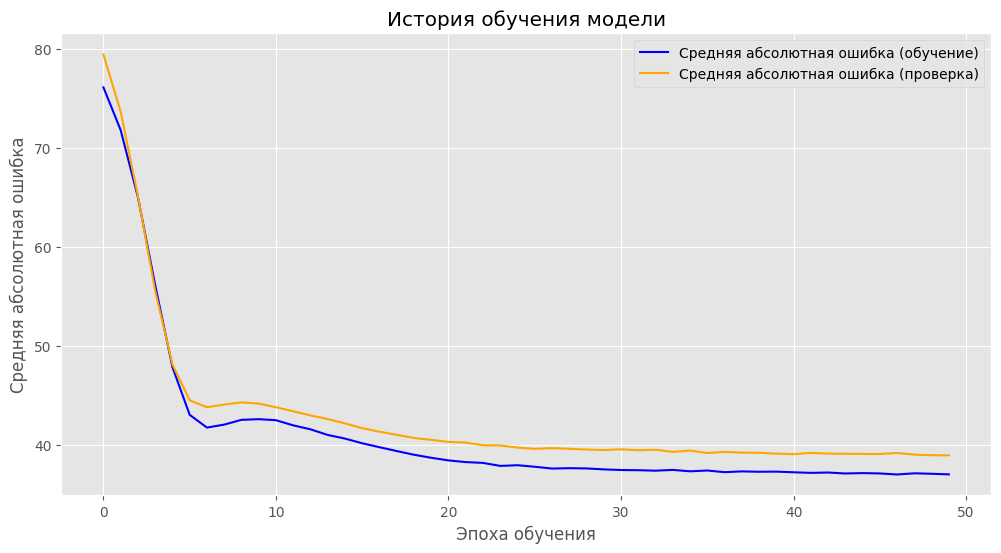

In [ ]:
# Обучение модели на простых данных

model_simple = Sequential()
model_simple.add(BatchNormalization(input_dim=x_train_01.shape[1]))
model_simple.add(Dense(128, activation='relu'))
model_simple.add(Dense(1000, activation='tanh'))
model_simple.add(Dense(100, activation='relu'))
model_simple.add(Dense(1, activation='linear'))

model_simple.compile(optimizer=Adam(learning_rate=1e-5), loss='mse', metrics=['mae'])

history = model_simple.fit(x_train_01,
                    y_train,
                    epochs=50,
                    batch_size=256,
                    validation_split=0.15,
                    verbose=1)

plot_history(history)

**Как оценить работу сети?**

In [ ]:
# Проверка работы сети - предсказание на тренировочной выборке
pred = model_simple.predict(x_train_01)

# Расчет среднего значения ошибки
print((abs(pred - y_train)).mean())         # Расчет вручную
print(mean_absolute_error(pred, y_train))   # Расчет с помощью готовой функции

1968/1968 [==============================] - 3s 2ms/step
37.28376088732268
37.28376088732268


Полученные значения буквально означают, что наша модель ошибается в среднем на 37 тысяч рублей. Скажем честно, хотелось бы видеть показатели получше.

Прежде чем двинемся дальше, напишем функцию, которая показывает разбор между реальными и предсказанными значениями:

In [ ]:
# Функция оценки результатов и вывода оценки

def eval_net(model, x_train, y_train, y_scaler = None, n = 5, limit = 1000):
    plt.style.use('default')

    pred = model.predict(x_train)             # Предсказание на тренировочной выборке
    if y_scaler:                              # Если есть нормирование - то денормировать
        pred = y_scaler.inverse_transform(pred)
        print('денормирование y_train')

    print('Средняя абсолютная ошибка:', mean_absolute_error(pred, y_train), '\n')

    for i in range(n):
        print('Реальное значение: {:6.2f}  Предсказанное значение: {:6.2f}  Разница: {:6.2f}'.format(y_train[i, 0],
                                                                                                    pred[i, 0],
                                                                                                    abs(y_train[i, 0] - pred[i, 0])))
    # Построение картинки разброса предсказанных и верных значений зарплаты
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(y_train, pred)                 # Отрисовка точечного графика
    ax.set_xlim(0, limit)                     # Пределы по x, y
    ax.set_ylim(0, limit)
    ax.plot(plt.xlim(), plt.ylim(), 'r')      # Отрисовка диагональной линии
    plt.xlabel('Правильные значения')
    plt.ylabel('Предсказания')
    plt.grid()
    plt.show()

Функция eval_net производит оценку результатов работы нейронной сети:
 - метод predict принимает на вход данные, по которым нужно сделать предсказания
 - дальше производим денормировку предсказаний, если необходимо
 - считаем среднюю абсолютную ошибку
 - строим точечный график зависимости предсказаний от верных ответов

1968/1968 [==============================] - 3s 2ms/step
Средняя абсолютная ошибка: 37.28376088732268 

Реальное значение:  40.00  Предсказанное значение:  45.48  Разница:   5.48
Реальное значение:  40.00  Предсказанное значение:  63.16  Разница:  23.16
Реальное значение: 300.00  Предсказанное значение: 127.72  Разница: 172.28
Реальное значение: 180.00  Предсказанное значение: 132.23  Разница:  47.77
Реальное значение:  40.00  Предсказанное значение:  43.37  Разница:   3.37


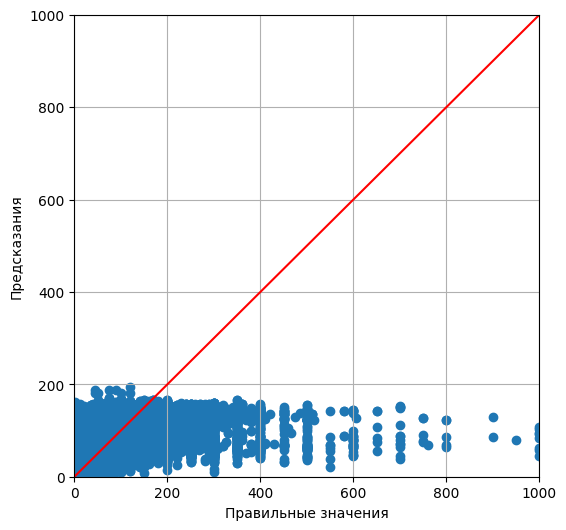

In [ ]:
eval_net(model_simple, x_train_01, y_train)

В идеале значения на графике должны располагаться вдоль красной диагональной линии

##Нормализация данных зарплаты

На следующем шаге мы нормализуем значение зарплаты, которое предсказывает нейронная сеть

In [ ]:
# Для нормализации данных используется готовый инструмент
y_scaler = StandardScaler()

# Нормализация выходных данных по стандартному нормальному распределению
y_train_scaled = y_scaler.fit_transform(y_train)

Воспользуемся для этого стандартным инструментом библиотеки `sklearn` - `StandardScaler`'ом, с помощью которого сможем преобразовать наши данные к нормальному распределению

In [ ]:
# Проверка нормализации
print(y_train_scaled.shape)
print(f'Оригинальное значение зарплаты:  {y_train[1, 0]}')
print(f'Нормированное значение зарплаты: {y_train_scaled[1, 0]}')

# Вывод границ ненормализованных и нормализованных данных
print(y_train.mean(), y_train.std())
print(y_train_scaled.mean(), y_train_scaled.std())

(62967, 1)
Оригинальное значение зарплаты:  40.0
Нормированное значение зарплаты: -0.5247188471924004
77.97875799228167 72.3792526140306
8.124744227091525e-18 1.0


In [ ]:
y_train_scaled.min(), y_train_scaled.max()

(-1.0773495881216906, 40.3709783740056)

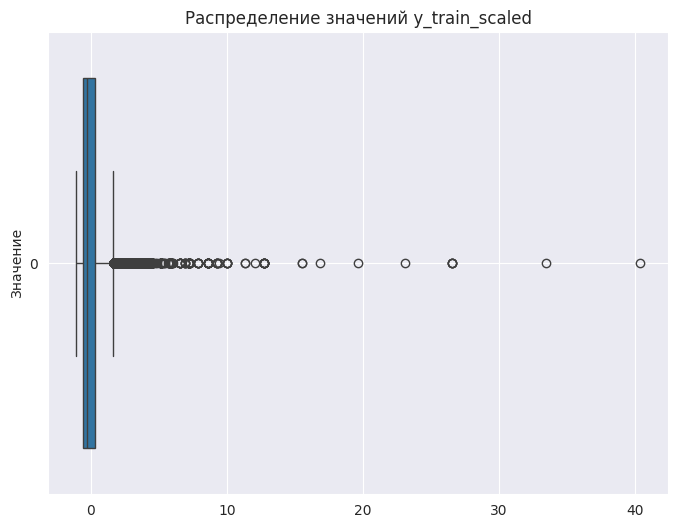

In [ ]:
import seaborn as sns
sns.set_style('dark')

# Вывод горизонтального box plot
plt.figure(figsize=(8, 6))
sns.boxplot(data=y_train_scaled, orient='h')
plt.title('Распределение значений y_train_scaled')
plt.ylabel('Значение')
plt.grid(True)
plt.show()



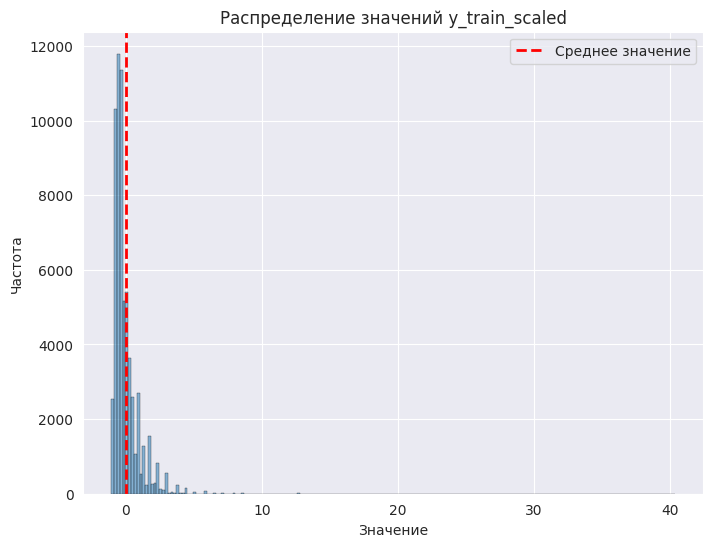

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Вывод гистограммы
plt.figure(figsize=(8, 6))
sns.histplot(y_train_scaled, bins=200, color='skyblue', edgecolor='black')
plt.title('Распределение значений y_train_scaled')
plt.xlabel('Значение')
plt.ylabel('Частота')
plt.grid(True)

# Добавление вертикальной линии
plt.axvline(x=y_train_scaled.mean(), color='r', linestyle='--', linewidth=2, label='Среднее значение')
plt.legend()

plt.show()



Мы нормировали значения зарплат в нашем наборе данных. В итоге полученный массив `y_train_scaled` обладает следующими характеристиками:
- среднее значение массива практически равно 0
- среднеквадратичное отклонение практически равно 1

Подобные значения, как показывает практика, значительно лучше анализируются нейронными сетями. Проверим это на нашей задаче:


Epoch 1/50
210/210 [==============================] - 3s 5ms/step - loss: 0.8805 - mae: 0.5640 - val_loss: 0.8963 - val_mae: 0.5741
Epoch 2/50
210/210 [==============================] - 1s 4ms/step - loss: 0.7968 - mae: 0.5275 - val_loss: 0.8516 - val_mae: 0.5507
Epoch 3/50
210/210 [==============================] - 1s 4ms/step - loss: 0.7812 - mae: 0.5204 - val_loss: 0.8403 - val_mae: 0.5410
Epoch 4/50
210/210 [==============================] - 1s 4ms/step - loss: 0.7734 - mae: 0.5165 - val_loss: 0.8359 - val_mae: 0.5337
Epoch 5/50
210/210 [==============================] - 1s 4ms/step - loss: 0.7688 - mae: 0.5127 - val_loss: 0.8326 - val_mae: 0.5310
Epoch 6/50
210/210 [==============================] - 1s 4ms/step - loss: 0.7649 - mae: 0.5105 - val_loss: 0.8286 - val_mae: 0.5380
Epoch 7/50
210/210 [==============================] - 1s 4ms/step - loss: 0.7626 - mae: 0.5103 - val_loss: 0.8292 - val_mae: 0.5265
Epoch 8/50
210/210 [==============================] - 1s 4ms/step - loss: 0.

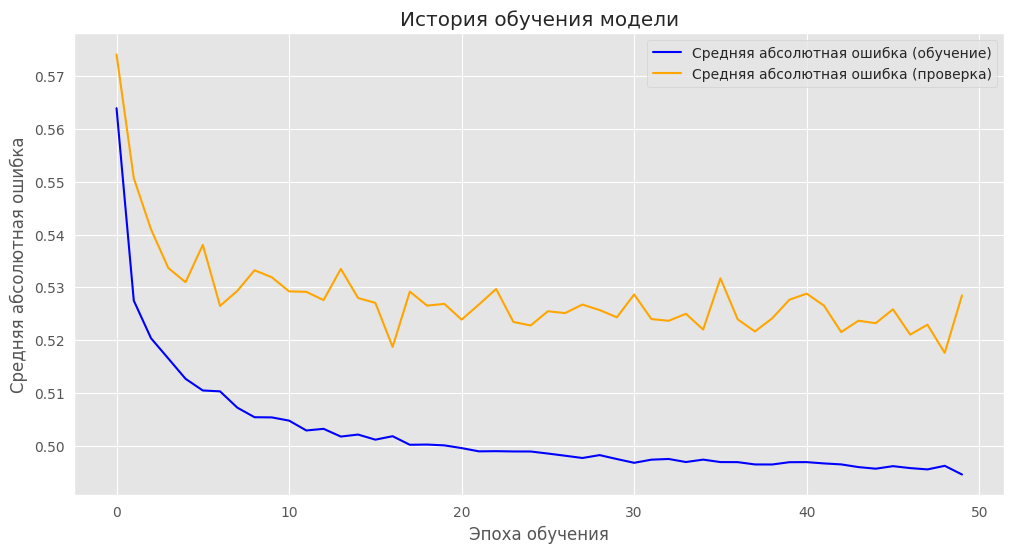

In [ ]:
# Обучение модели на простых данных с нормализованной зарплатой
model_simple = Sequential()
model_simple.add(BatchNormalization(input_dim=x_train_01.shape[1]))
model_simple.add(Dense(128, activation='relu'))
model_simple.add(Dense(1000, activation='tanh'))
model_simple.add(Dense(100, activation='relu'))
model_simple.add(Dense(1, activation='linear'))

model_simple.compile(optimizer=Adam(learning_rate=1e-5), loss='mse', metrics=['mae'])

history = model_simple.fit(x_train_01,
                    y_train_scaled,
                    epochs=50,
                    batch_size=256,
                    validation_split=0.15,
                    verbose=1)

plot_history(history)

In [ ]:
# Проверка работы сети - предсказание на тренировочной выборке
pred = model_simple.predict(x_train_01)

print(mean_absolute_error(pred, y_train_scaled))   # Расчет с помощью готовой функции

1968/1968 [==============================] - 4s 2ms/step
0.5024546044356528


**Оценка результатов**


1968/1968 [==============================] - 4s 2ms/step
денормирование y_train
Средняя абсолютная ошибка: 36.36728883284156 

Реальное значение:  40.00  Предсказанное значение:  49.12  Разница:   9.12
Реальное значение:  40.00  Предсказанное значение:  54.10  Разница:  14.10
Реальное значение: 300.00  Предсказанное значение: 128.48  Разница: 171.52
Реальное значение: 180.00  Предсказанное значение: 133.93  Разница:  46.07
Реальное значение:  40.00  Предсказанное значение:  47.85  Разница:   7.85


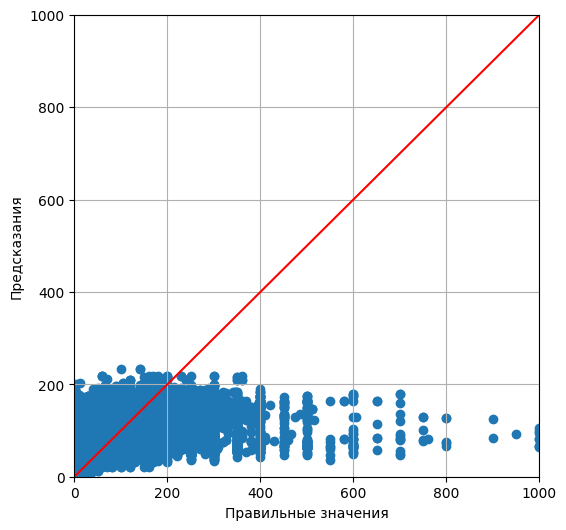

In [ ]:
eval_net(model_simple, x_train_01, y_train, y_scaler)

Полученное значение ошибки немного лучше предыдущего 36 тысяч против 37.

Поэтому мы продолжаем наши эксперименты и создадим обучающий набор на основе текстовых данных нашей исходной таблицы

##Подготовка текстовых данных "Должность"


Вначале соберем обучающий набор на основе столбцов с текущей и желаемой должностью:

In [ ]:
# Функция извлечения данных о профессии

def extract_prof_text(row_list):
    result = []

    # Для всех строк таблицы: собрать значения
    # столбцов желаемой и прошлой должности
    # если есть информация о зарплате

    for row in row_list:
        if extract_salary(row[COL_SALARY]) > 0:
            result.append(str(row[COL_POS_SEEK]) + ' ' + str(row[COL_POS_PREV]))

    # Возврат в виде массива
    return result

In [ ]:
# Извлечение текстов о профессии для выборки
prof_text = extract_prof_text(df.values)

# Пример текста о профессии из резюме
print(df.values[120])
print(prof_text[120])

['Мужчина ,  33 года , родился 8 октября 1985' '250000 руб.'
 'Руководитель BI' 'Москва , не готов к переезду , готов к командировкам'
 'полная занятость' 'полный день'
 'Опыт работы 11 лет 6 месяцев  Руководитель BI 250 000 руб. Информационные технологии, интернет, телеком Инженер Аналитик Занятость: полная занятость График работы: полный день Опыт работы 11 лет 6 месяцев Декабрь 2017 — по настоящее время 1 год 5 месяцев ЭркаФарм Россия , erkapharm.com Медицина, фармацевтика, аптеки ... Аптека, оптика Руководитель отдела аналитики Стратегическая цель: создание единой корпоративной автоматизированной информационно-аналитической системы бизнес анализа; MDM: ведение и поддержка в актуальном состоянии мастер-справочников компании; разработка новых справочников\\атрибутов для обеспечения деятельности подразделений компании; контроль бизнес-процессов в части, касающейся мастер-данных; написание документов, закрепляющих регламентные нормы по ведению мастер-справочников; ETL: загрузка данных 

In [ ]:
# Преобразование текстовых данных в числовые/векторные для обучения нейросетью

# Используется встроенный в Keras токенизатор для разбиения текста и построения частотного словаря
tokenizer = Tokenizer(num_words=3000, # объем словаря
                      filters='!"#$%&()*+,-–—./:;<=>?@[\\]^_`{|}~\t\n\xa0', # убираемые из текста ненужные символы
                      lower=True, # приведение слов к нижнему регистру
                      split=' ', # разделитель слов
                      oov_token='unknown', # указание разделять по словам, а не по единичным символам
                      char_level=False # токен для слов, которые не вошли в словарь
                      )

tokenizer.fit_on_texts(prof_text)

In [ ]:
items = list(tokenizer.word_index.items())       # Получение индексов слов
print(items[:50])                                # Посмотр 50 самых часто встречающихся слов
print("Размер словаря", len(items))              # Длина словаря

[('unknown', 1), ('инженер', 2), ('специалист', 3), ('по', 4), ('менеджер', 5), ('администратор', 6), ('руководитель', 7), ('системный', 8), ('отдела', 9), ('программист', 10), ('ведущий', 11), ('проектов', 12), ('разработчик', 13), ('it', 14), ('поддержки', 15), ('аналитик', 16), ('и', 17), ('технической', 18), ('проекта', 19), ('начальник', 20), ('ит', 21), ('директор', 22), ('интернет', 23), ('с', 24), ('главный', 25), ('старший', 26), ('оператор', 27), ('продажам', 28), ('работе', 29), ('технический', 30), ('монтажник', 31), ('систем', 32), ('developer', 33), ('web', 34), ('связи', 35), ('клиентами', 36), ('информационных', 37), ('консультант', 38), ('группы', 39), ('1с', 40), ('технологий', 41), ('заместитель', 42), ('manager', 43), ('техник', 44), ('дизайнер', 45), ('помощник', 46), ('службы', 47), ('магазина', 48), ('сервисный', 49), ('маркетолог', 50)]
Размер словаря 10025


In [ ]:
# Преобразование текстов в последовательность индексов согласно частотному словарю
prof_seq = tokenizer.texts_to_sequences(prof_text)

**Создание обучающей и проверочной выборок**


In [ ]:
# Преобразование последовательностей индексов в bag of words
x_train_prof_01 = tokenizer.sequences_to_matrix(prof_seq)

In [ ]:
# Проверка результата
print(x_train_prof_01.shape)

(62967, 3000)


In [ ]:
# Проверка получившихся данных
n = 0
print(prof_text[n])                       # Профессия в тексте
print(prof_seq[n])                        # Профессия в индексах слов
print(x_train_prof_01[n][0:100])          # Профессия в bag of words

Специалист по поддержке чата(support team) домашний агент Генеральный директор
[3, 4, 130, 987, 235, 114, 1, 346, 168, 22]
[0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [ ]:
# Освобождение памяти от ненужных более объектов
del prof_text, prof_seq, tokenizer

Мы подготовили выборку на основе текстовых данных о должности пользователя. Попробуем обучить нейронную сеть на основе собранных данных

**Обучение модели на простых текстовых данных**


Epoch 1/50
210/210 [==============================] - 3s 7ms/step - loss: 0.9856 - mae: 0.6457 - val_loss: 1.0638 - val_mae: 0.6607
Epoch 2/50
210/210 [==============================] - 1s 5ms/step - loss: 0.9805 - mae: 0.6395 - val_loss: 1.0581 - val_mae: 0.6564
Epoch 3/50
210/210 [==============================] - 1s 5ms/step - loss: 0.9730 - mae: 0.6348 - val_loss: 1.0491 - val_mae: 0.6512
Epoch 4/50
210/210 [==============================] - 1s 5ms/step - loss: 0.9623 - mae: 0.6286 - val_loss: 1.0358 - val_mae: 0.6462
Epoch 5/50
210/210 [==============================] - 1s 5ms/step - loss: 0.9480 - mae: 0.6227 - val_loss: 1.0196 - val_mae: 0.6380
Epoch 6/50
210/210 [==============================] - 1s 5ms/step - loss: 0.9303 - mae: 0.6130 - val_loss: 0.9990 - val_mae: 0.6300
Epoch 7/50
210/210 [==============================] - 1s 5ms/step - loss: 0.9094 - mae: 0.6033 - val_loss: 0.9765 - val_mae: 0.6187
Epoch 8/50
210/210 [==============================] - 1s 5ms/step - loss: 0.

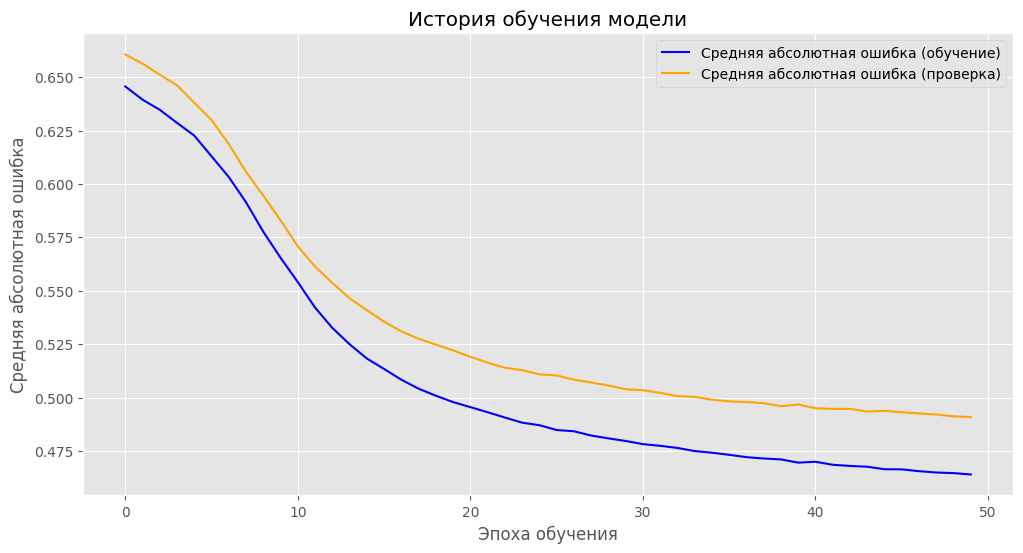

In [ ]:
# Обучение модели на данных о профессии

model_prof = Sequential()
model_prof.add(Dense(20, activation='relu', input_dim=x_train_prof_01.shape[1]))
model_prof.add(Dense(500, activation='relu'))
model_prof.add(Dense(1, activation='linear'))

model_prof.compile(optimizer=Adagrad(learning_rate=1e-3), loss='mse', metrics=['mae'])

history = model_prof.fit(x_train_prof_01,
                    y_train_scaled,
                    batch_size=256,
                    epochs=50,
                    validation_split=0.15,
                    verbose=1)

plot_history(history)

**Оценка результатов**


1968/1968 [==============================] - 5s 2ms/step
денормирование y_train
Средняя абсолютная ошибка: 33.80480591329763 

Реальное значение:  40.00  Предсказанное значение: 120.89  Разница:  80.89
Реальное значение:  40.00  Предсказанное значение:  52.58  Разница:  12.58
Реальное значение: 300.00  Предсказанное значение: 211.85  Разница:  88.15
Реальное значение: 180.00  Предсказанное значение: 111.60  Разница:  68.40
Реальное значение:  40.00  Предсказанное значение:  60.03  Разница:  20.03


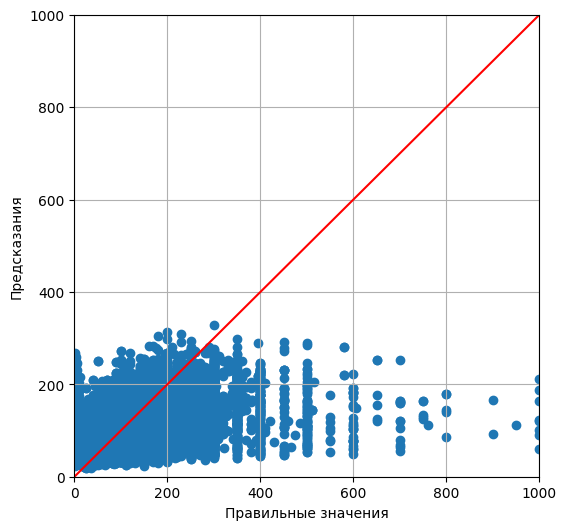

In [ ]:
eval_net(model_prof, x_train_prof_01, y_train, y_scaler)

Мы получили лучшее на данный момент значение ошибки: 33 тыс. руб

И это только на основе одних лищь текстовых данных о должности.

В нашей исходной таблице было еще одно текстовой поле - это информация об опыте работы. На следующем шаге мы сформируем выборку на основе этих данных

##Подготовка текстовых данных "Опыт работы"


In [ ]:
# Функция извлечения данных описания опыта работы

def extract_exp_text(row_list):
    result = []

    # Для всех строк таблицы: собрать значения опыта работы,
    # если есть информация о зарплате
    for row in row_list:
        if extract_salary(row[COL_SALARY]) > 0:
            result.append(str(row[COL_EXP]))

    # Возврат в виде массива
    return result

In [ ]:
# Извлечение текстов об опыте работы для выборки
exp_text = extract_exp_text(df.values)

# Пример текста об опыте работы из резюме
print(df.values[120])
print(exp_text[120])

['Мужчина ,  33 года , родился 8 октября 1985' '250000 руб.'
 'Руководитель BI' 'Москва , не готов к переезду , готов к командировкам'
 'полная занятость' 'полный день'
 'Опыт работы 11 лет 6 месяцев  Руководитель BI 250 000 руб. Информационные технологии, интернет, телеком Инженер Аналитик Занятость: полная занятость График работы: полный день Опыт работы 11 лет 6 месяцев Декабрь 2017 — по настоящее время 1 год 5 месяцев ЭркаФарм Россия , erkapharm.com Медицина, фармацевтика, аптеки ... Аптека, оптика Руководитель отдела аналитики Стратегическая цель: создание единой корпоративной автоматизированной информационно-аналитической системы бизнес анализа; MDM: ведение и поддержка в актуальном состоянии мастер-справочников компании; разработка новых справочников\\атрибутов для обеспечения деятельности подразделений компании; контроль бизнес-процессов в части, касающейся мастер-данных; написание документов, закрепляющих регламентные нормы по ведению мастер-справочников; ETL: загрузка данных 

In [ ]:
# Преобразование текстовых данных в числовые/векторные для обучения нейросетью

# Используется встроенный в Keras токенизатор для разбиения текста и построения частотного словаря
tokenizer = Tokenizer(num_words=3000, # объем словаря
                      filters='!"#$%&()*+,-–—./:;<=>?@[\\]^_`{|}~\t\n\xa0', # убираемые из текста ненужные символы
                      lower=True, # приведение слов к нижнему регистру
                      split=' ', # разделитель слов
                      oov_token='unknown', # указание разделять по словам, а не по единичным символам
                      char_level=False # токен для слов, которые не вошли в словарь
                      )

# Построение частотного словаря по текстам профессий
tokenizer.fit_on_texts(exp_text)

In [ ]:
items = list(tokenizer.word_index.items())       # Получение индексов слов
print(items[:50])                                # Посмотр 50 самых часто встречающихся слов
print("Размер словаря", len(items))              # Длина словаря

[('unknown', 124327), ('и', 2), ('в', 3), ('по', 4), ('с', 5), ('на', 6), ('работы', 7), ('месяцев', 8), ('•', 9), ('для', 10), ('1', 11), ('разработка', 12), ('ru', 13), ('интернет', 14), ('2', 15), ('работа', 16), ('опыт', 17), ('года', 18), ('интеграция', 19), ('месяца', 20), ('3', 21), ('москва', 22), ('системная', 23), ('технологии', 24), ('www', 25), ('время', 26), ('системы', 27), ('год', 28), ('лет', 29), ('контроль', 30), ('настройка', 31), ('ооо', 32), ('информационные', 33), ('оборудования', 34), ('компании', 35), ('4', 36), ('5', 37), ('бизнес', 38), ('7', 39), ('поддержка', 40), ('организация', 41), ('2018', 42), ('сети', 43), ('ит', 44), ('8', 45), ('администрирование', 46), ('2017', 47), ('данных', 48), ('систем', 49), ('инженер', 50)]
Размер словаря 325174


In [ ]:
for i in items:
  if i[0] == '300':
    print(i)

('300', 1390)


In [ ]:
# Преобразование текстов в последовательность индексов согласно частотному словарю
exp_seq = tokenizer.texts_to_sequences(exp_text)

**Создание обучающей и проверочной выборок**

In [ ]:
# Преобразование последовательностей индексов в bag of words
x_train_exp_01 = tokenizer.sequences_to_matrix(exp_seq)

In [ ]:
# Проверка результата
print(x_train_exp_01.shape)
print(x_train_exp_01[0][0:100])

(62967, 3000)
[0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 0.
 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.
 0. 0. 1. 0.]


In [ ]:
# Проверка получившихся данных
n = 0
print(exp_text[n])                       # Опыт работы в тексте
print(exp_seq[n])                        # Опыт работы в индексах слов
print(x_train_exp_01[n][0:100])          # Опыт работы в bag of words

Опыт работы 3 года 9 месяцев  Специалист по поддержке чата(support team) домашний агент 40 000 руб. Информационные технологии, интернет, телеком Системный администратор Сотовые, Беспроводные технологии Телекоммуникации Занятость: полная занятость График работы: полный день Опыт работы 3 года 9 месяцев Май 2012 — Январь  2016 3 года 9 месяцев ООО "Гольфстрим" Республика Башкортостан Строительство, недвижимость, эксплуатация, проектирование ... Строительство жилищное Управление и эксплуатация недвижимости Генеральный директор Руководство, отладка деловых связей, заключение договоров, развитие организации Ключевые навыки Теперь резюме открыто всему интернету — изменить можно в настройках видимости. Заключение договоров Деловое общение Деловая коммуникация Пользователь ПК Ведение переговоров Управление персоналом Деловая переписка Составление договоров Телефонные переговоры Грамотная речь MS Outlook Водительское удостоверение категории B Работа в команде Возникли неполадки. Попробуйте еще 

In [ ]:
# Освобождение памяти от ненужных более объектов
del exp_text, exp_seq, tokenizer

**Обучение модели**


Epoch 1/50
210/210 [==============================] - 4s 7ms/step - loss: 0.5741 - mae: 0.4202 - val_loss: 0.5379 - val_mae: 0.4086
Epoch 2/50
210/210 [==============================] - 1s 5ms/step - loss: 0.4342 - mae: 0.3588 - val_loss: 0.5198 - val_mae: 0.4379
Epoch 3/50
210/210 [==============================] - 1s 5ms/step - loss: 0.3359 - mae: 0.3279 - val_loss: 0.5060 - val_mae: 0.3871
Epoch 4/50
210/210 [==============================] - 1s 5ms/step - loss: 0.2534 - mae: 0.3001 - val_loss: 0.4771 - val_mae: 0.3717
Epoch 5/50
210/210 [==============================] - 1s 5ms/step - loss: 0.1920 - mae: 0.2707 - val_loss: 0.4673 - val_mae: 0.3687
Epoch 6/50
210/210 [==============================] - 1s 5ms/step - loss: 0.1618 - mae: 0.2533 - val_loss: 0.4848 - val_mae: 0.3625
Epoch 7/50
210/210 [==============================] - 1s 5ms/step - loss: 0.1369 - mae: 0.2379 - val_loss: 0.4536 - val_mae: 0.3465
Epoch 8/50
210/210 [==============================] - 1s 5ms/step - loss: 0.

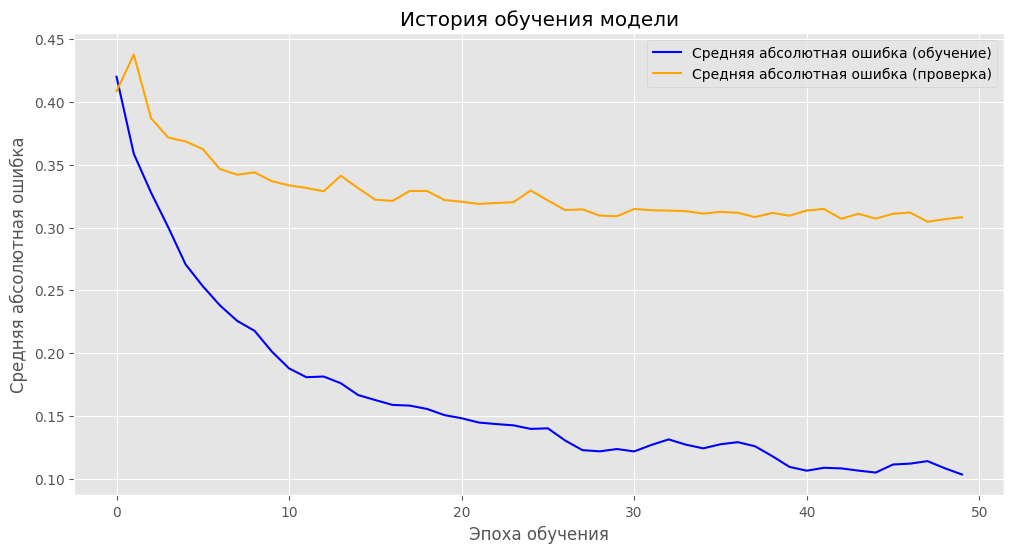

In [ ]:
# Обучение модели на данных об опыте работы (должности)

model_exp = Sequential()
model_exp.add(Dense(30, activation='relu', input_dim=x_train_exp_01.shape[1]))
model_exp.add(Dense(800, activation='relu'))
model_exp.add(Dropout(0.3))
model_exp.add(Dense(1, activation='linear'))

model_exp.compile(optimizer=Adam(learning_rate=1e-3),
                  loss='mse',
                  metrics=['mae'])

history = model_exp.fit(x_train_exp_01,
                    y_train_scaled,
                    batch_size=256,
                    epochs=50,
                    validation_split=0.15,
                    verbose=1)

plot_history(history)

**Оценка результатов**


1968/1968 [==============================] - 4s 2ms/step
денормирование y_train
Средняя абсолютная ошибка: 9.222826868764065 

Реальное значение:  40.00  Предсказанное значение:  49.61  Разница:   9.61
Реальное значение:  40.00  Предсказанное значение:  51.04  Разница:  11.04
Реальное значение: 300.00  Предсказанное значение: 312.31  Разница:  12.31
Реальное значение: 180.00  Предсказанное значение: 176.28  Разница:   3.72
Реальное значение:  40.00  Предсказанное значение:  42.70  Разница:   2.70


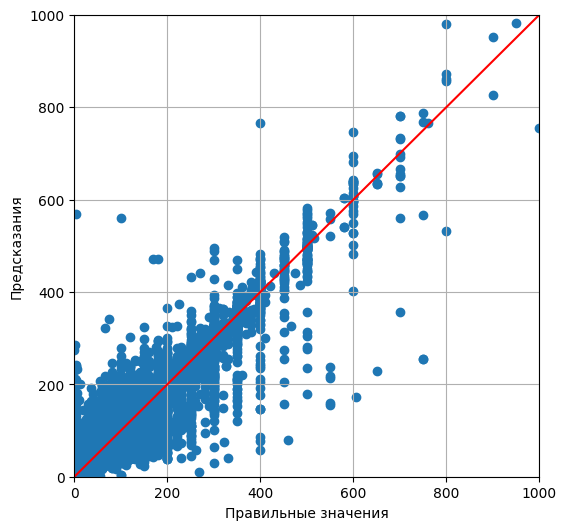

In [ ]:
eval_net(model_exp, x_train_exp_01, y_train, y_scaler)

In [ ]:
# Освобождение памяти
del model_simple, model_prof, model_exp

И это самый лучший результат. Очень хорошая цифра: 9 тыс. руб

В финальной части мы создадим обещанную сложную нелинейную архитектуру нейронной сети. Мы создадим модель, у которой будет три входных набора данных:

- числовой набор (это наша первая выборка)
- текстовый набор (набор, содержащий информацию о должностях)
- текстовый набор (набор, содержащий информацию об опыте работы)

##Обучение нейронной сети класса Model

In [ ]:
input1 = Input((x_train_01.shape[1],))
input2 = Input((x_train_prof_01.shape[1],))
input3 = Input((x_train_exp_01.shape[1],))

x1 = input1                               # Ветка 1
x1 = Dense(128, activation="relu")(x1)
x1 = Dense(1000, activation="tanh")(x1)
x1 = Dense(100, activation="relu")(x1)

x2 = input2                               # Ветка 2
x2 = Dense(20, activation="relu")(x2)
x2 = Dense(500, activation="relu")(x2)
x2 = Dropout(0.3)(x2)

x3 = input3                               # Ветка 3
x3 = Dense(30, activation="relu")(x3)
x3 = Dense(800, activation="relu")(x3)
x3 = Dropout(0.3)(x3)

x = concatenate([x1, x2, x3])             # Объединение трех веток

x = Dense(15, activation='relu')(x)       # Промежуточный слой
x = Dropout(0.5)(x)
x = Dense(1, activation='linear')(x)      # Финальный регрессирующий нейрон

# В Model передаются входы и выход
model_final = Model((input1, input2, input3), x)

Практическое отличие от модели Sequential в том, что мы определяем слои как переменные, и у каждого слоя указан его вход, то есть откуда ему приходят на вход данные, таким образом:

    x1 = input1                               
    x1 = Dense(128, activation="relu")(x1) #(x1) - то, откуда придут данные на полносвязный слой

Далее необходимо создать нашу нейронную сеть из класса Model. В качестве параметров нужно передать нейронные слои/слой, котрые являются входами сети, и нейронные слои/слой выхода сети.

    model_final = Model((input1, input2, input3), x)

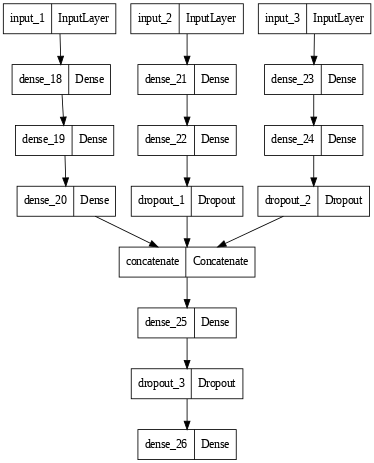

In [ ]:
utils.plot_model(model_final, dpi=60)

Вот так выглядит структура созданной нейронной сети

Остальные шаги выполняются практически так же как и для последовательной модели. В методе fit в качестве обучающих данных нужно передать спискок из наборов данных для каждого входа нейронной сети.

In [ ]:
model_final.compile(optimizer=Adam(learning_rate=1e-3), loss='mse', metrics=['mae'])

history = model_final.fit([x_train_01, x_train_prof_01, x_train_exp_01],
                           y_train_scaled,
                           batch_size=256,
                           epochs=50,
                           validation_split=0.15,
                           verbose=1)

Epoch 1/50
210/210 [==============================] - 8s 13ms/step - loss: 0.6145 - mae: 0.4335 - val_loss: 0.5053 - val_mae: 0.3784
Epoch 2/50
210/210 [==============================] - 2s 9ms/step - loss: 0.4814 - mae: 0.3829 - val_loss: 0.4515 - val_mae: 0.3732
Epoch 3/50
210/210 [==============================] - 2s 9ms/step - loss: 0.4107 - mae: 0.3642 - val_loss: 0.4615 - val_mae: 0.3629
Epoch 4/50
210/210 [==============================] - 2s 8ms/step - loss: 0.3588 - mae: 0.3468 - val_loss: 0.4280 - val_mae: 0.3372
Epoch 5/50
210/210 [==============================] - 2s 8ms/step - loss: 0.3210 - mae: 0.3346 - val_loss: 0.4499 - val_mae: 0.3412
Epoch 6/50
210/210 [==============================] - 2s 9ms/step - loss: 0.3067 - mae: 0.3281 - val_loss: 0.4368 - val_mae: 0.3354
Epoch 7/50
210/210 [==============================] - 2s 12ms/step - loss: 0.3053 - mae: 0.3255 - val_loss: 0.4312 - val_mae: 0.3298
Epoch 8/50
210/210 [==============================] - 3s 13ms/step - loss:

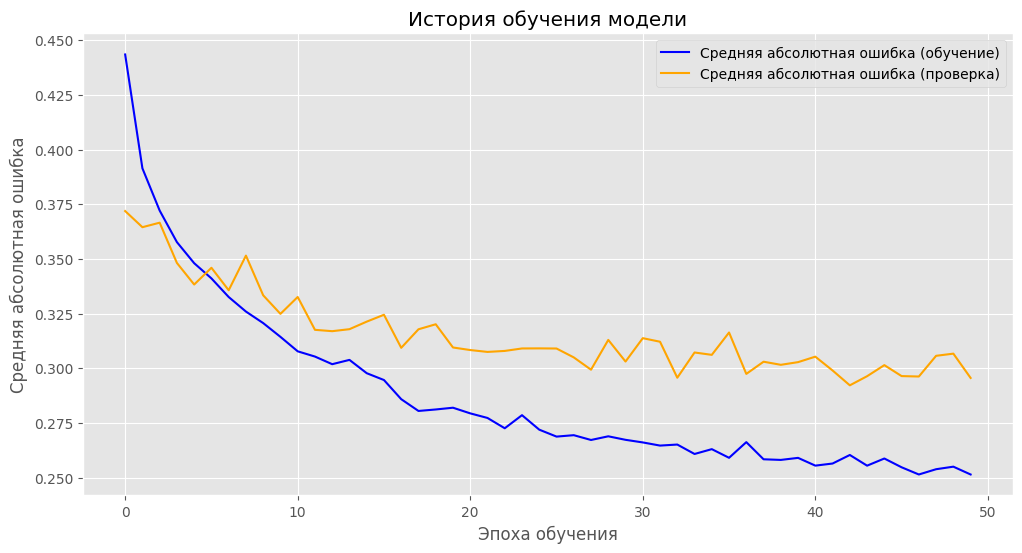

In [ ]:
plot_history(history)

1968/1968 [==============================] - 4s 2ms/step
денормирование y_train
Средняя абсолютная ошибка: 12.871696185520197 

Реальное значение:  40.00  Предсказанное значение:  42.75  Разница:   2.75
Реальное значение:  40.00  Предсказанное значение:  50.71  Разница:  10.71
Реальное значение: 300.00  Предсказанное значение: 312.65  Разница:  12.65
Реальное значение: 180.00  Предсказанное значение: 180.90  Разница:   0.90
Реальное значение:  40.00  Предсказанное значение:  39.25  Разница:   0.75


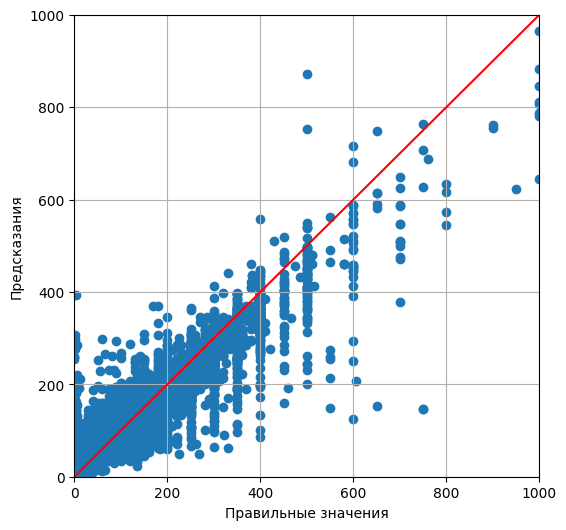

In [ ]:
eval_net(model_final, [x_train_01, x_train_prof_01, x_train_exp_01], y_train, y_scaler)

**Вывод**

Мы провели несколько экспериментов с имеющимися данными. Получили две модели, дающие довольно хороший результат:
- линейная модель на основе анализа опыта работы (Ошибка: 9 тыс. руб)
- нелинейная модель на основе анализа всех имеющихся данных (Ошибка: 12 тыс. руб)

Дальнейшая работа по улучшению показателей может вестись с двумя последними архитектурами
